In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glovedata/glove.6B.200d.txt
/kaggle/input/glovedata/glove.6B.50d.txt
/kaggle/input/glovedata/glove.6B.100d.txt
/kaggle/input/ncu-im5033-polarity-21/sample_submission.csv
/kaggle/input/ncu-im5033-polarity-21/test_no_answer.csv
/kaggle/input/ncu-im5033-polarity-21/train.csv


In [2]:
df_train = pd.read_csv('../input/ncu-im5033-polarity-21/train.csv')
df_test = pd.read_csv('../input/ncu-im5033-polarity-21/test_no_answer.csv')
sample_submission = pd.read_csv('../input/ncu-im5033-polarity-21/sample_submission.csv')

# Preprocessing

In [3]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
stop_words = stopwords.words('english')



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data
def lemma_word(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data
df_train['TEXT'] = df_train['TEXT'].apply(lambda X: remove_punctuations(X))
df_train['TEXT'] = df_train['TEXT'].apply(lambda X: lemma_word(X))
df_test['TEXT'] = df_test['TEXT'].apply(lambda X: remove_punctuations(X))
df_test['TEXT'] = df_test['TEXT'].apply(lambda X: lemma_word(X))

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
MAX_NB_WORDS = 20000


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_train['TEXT'])
word_indexs = tokenizer.word_index
total_vocab = len(word_indexs)

sequences_train=tokenizer.texts_to_sequences(df_train['TEXT'])
sequences_test=tokenizer.texts_to_sequences(df_test['TEXT'])
max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_test]))
train_padded=pad_sequences(sequences_train,maxlen=max_len)
test_padded=pad_sequences(sequences_test,maxlen=max_len)

In [6]:
total_vocab

9873

# 切train set、validation set和test set

In [7]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
labels = df_train['LABEL']
#labels=le.fit_transform(df_train['LABEL'])# for model1
#labels=to_categorical(df_train['LABEL'],num_classes=2) # for model

indices = np.arange(train_padded.shape[0])#洗牌
np.random.shuffle(indices)
train_padded = train_padded[indices]
labels = labels[indices]

x_train,x_val,y_train,y_val=train_test_split(train_padded,labels,test_size=0.2,random_state=10)
                                             

In [8]:
print('x_train shape:',x_train.shape)
print('y_train shape:',y_train.shape)
print('x_val shape:',x_val.shape)
print('y_val shape:',y_val.shape)
#x_train.reshape(x_train.shape[0],x_train.shape[1],1)
#x_val.reshape(x_val.shape[0],x_val.shape[1],1)

x_train shape: (8800, 36)
y_train shape: (8800,)
x_val shape: (2200, 36)
y_val shape: (2200,)


# 讀入Glove pretrain dataset

In [9]:
embeddings_index = {}
f = open(os.path.join('../input/glovedata', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((len(word_indexs)+1, EMBEDDING_DIM))

for word, i in word_indexs.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
len(word_indexs)

9873

# Plot Loss And Accuracy

In [12]:
import matplotlib.pyplot as plt
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()

# Build Model with Glove Embedding Matrix

# LSTM

In [13]:
import keras
from keras.layers import Embedding,Conv1D,MaxPooling1D,LSTM,GRU,GlobalMaxPool1D,Input,Bidirectional,Dense
from tensorflow.keras.models import Model,Sequential

model2 = Sequential()
model2.add(Embedding(total_vocab+1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len))
model2.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3,return_sequences='True'))
model2.add(GlobalMaxPool1D())
model2.add(Dense(16,activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 100)           987400    
_________________________________________________________________
lstm (LSTM)                  (None, 36, 100)           80400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,069,433
Trainable params: 1,069,433
Non-trainable params: 0
_________________________________________________________________


In [14]:
history2=model2.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10)

Epoch 1/10
275/275 [==============================] - 16s 51ms/step - loss: 0.6722 - accuracy: 0.5697 - val_loss: 0.5704 - val_accuracy: 0.7118
Epoch 2/10
275/275 [==============================] - 13s 47ms/step - loss: 0.5265 - accuracy: 0.7375 - val_loss: 0.5006 - val_accuracy: 0.7468
Epoch 3/10
275/275 [==============================] - 13s 49ms/step - loss: 0.4204 - accuracy: 0.8059 - val_loss: 0.5021 - val_accuracy: 0.7586
Epoch 4/10
275/275 [==============================] - 13s 48ms/step - loss: 0.3447 - accuracy: 0.8506 - val_loss: 0.5071 - val_accuracy: 0.7686
Epoch 5/10
275/275 [==============================] - 13s 48ms/step - loss: 0.2930 - accuracy: 0.8742 - val_loss: 0.5393 - val_accuracy: 0.7605
Epoch 6/10
275/275 [==============================] - 13s 49ms/step - loss: 0.2400 - accuracy: 0.9009 - val_loss: 0.6000 - val_accuracy: 0.7609
Epoch 7/10
275/275 [==============================] - 13s 48ms/step - loss: 0.1901 - accuracy: 0.9253 - val_loss: 0.6425 - val_accuracy:

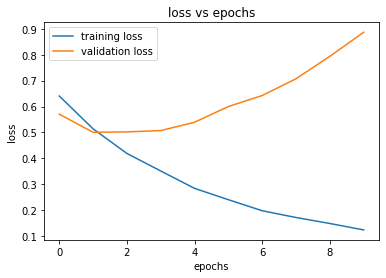

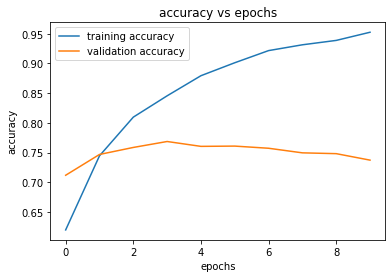

In [15]:
plot_graph(history2,'loss')
plot_graph(history2,'accuracy')

In [16]:
model2_y_pred = model2.predict(test_padded)

# Bi-directional LSTM

In [17]:
model3 = Sequential()
model3.add(Embedding(total_vocab+1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len))
model3.add(Bidirectional(LSTM(120, dropout=0.3, recurrent_dropout=0.3,return_sequences='True')))
model3.add(GlobalMaxPool1D())
model3.add(Dense(16,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])    
    
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           987400    
_________________________________________________________________
bidirectional (Bidirectional (None, 36, 240)           212160    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 240)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                3856      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,203,433
Trainable params: 1,203,433
Non-trainable params: 0
_________________________________________________________________


In [18]:
history3=model3.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10)

Epoch 1/10
275/275 [==============================] - 31s 99ms/step - loss: 0.6569 - accuracy: 0.5928 - val_loss: 0.5379 - val_accuracy: 0.7336
Epoch 2/10
275/275 [==============================] - 27s 97ms/step - loss: 0.4962 - accuracy: 0.7495 - val_loss: 0.5065 - val_accuracy: 0.7518
Epoch 3/10
275/275 [==============================] - 27s 98ms/step - loss: 0.4024 - accuracy: 0.8171 - val_loss: 0.5289 - val_accuracy: 0.7659
Epoch 4/10
275/275 [==============================] - 27s 98ms/step - loss: 0.3312 - accuracy: 0.8613 - val_loss: 0.5413 - val_accuracy: 0.7623
Epoch 5/10
275/275 [==============================] - 27s 97ms/step - loss: 0.2699 - accuracy: 0.8839 - val_loss: 0.5665 - val_accuracy: 0.7600
Epoch 6/10
275/275 [==============================] - 27s 96ms/step - loss: 0.2088 - accuracy: 0.9151 - val_loss: 0.6185 - val_accuracy: 0.7505
Epoch 7/10
275/275 [==============================] - 27s 97ms/step - loss: 0.1684 - accuracy: 0.9315 - val_loss: 0.7135 - val_accuracy:

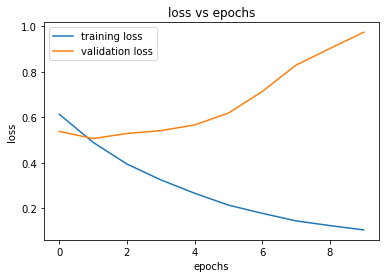

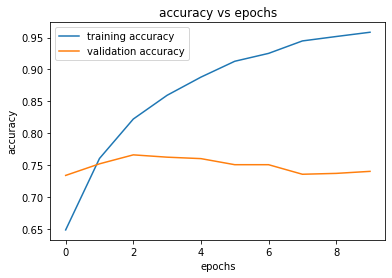

In [19]:
plot_graph(history3,'loss')
plot_graph(history3,'accuracy')

In [20]:
model3_y_pred = model3.predict(test_padded)

# GRU

In [21]:
from tensorflow.keras.models import Model,Sequential
from keras.layers import Embedding,Conv1D,MaxPooling1D,LSTM,GRU,GlobalMaxPool1D,Input,Bidirectional,Dense

model_gru = Sequential()
model_gru.add(Embedding(total_vocab+1,100,weights=[embedding_matrix],input_length=max_len,trainable=False))
model_gru.add(GRU(units=120,dropout=0.3,recurrent_dropout=0.3,return_sequences='True'))
model_gru.add(GlobalMaxPool1D())
model_gru.add(Dense(16,activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 36, 100)           987400    
_________________________________________________________________
gru (GRU)                    (None, 36, 120)           79920     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1936      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,069,273
Trainable params: 81,873
Non-trainable params: 987,400
_________________________________________________________________


In [22]:
history_gru=model_gru.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10)

Epoch 1/10
275/275 [==============================] - 14s 42ms/step - loss: 0.6648 - accuracy: 0.5781 - val_loss: 0.6115 - val_accuracy: 0.6541
Epoch 2/10
275/275 [==============================] - 11s 41ms/step - loss: 0.5767 - accuracy: 0.6915 - val_loss: 0.5607 - val_accuracy: 0.7045
Epoch 3/10
275/275 [==============================] - 12s 44ms/step - loss: 0.5525 - accuracy: 0.7113 - val_loss: 0.5494 - val_accuracy: 0.7136
Epoch 4/10
275/275 [==============================] - 11s 41ms/step - loss: 0.5338 - accuracy: 0.7324 - val_loss: 0.5212 - val_accuracy: 0.7423
Epoch 5/10
275/275 [==============================] - 11s 41ms/step - loss: 0.4966 - accuracy: 0.7601 - val_loss: 0.5182 - val_accuracy: 0.7518
Epoch 6/10
275/275 [==============================] - 12s 44ms/step - loss: 0.4839 - accuracy: 0.7682 - val_loss: 0.5259 - val_accuracy: 0.7359
Epoch 7/10
275/275 [==============================] - 11s 41ms/step - loss: 0.4731 - accuracy: 0.7662 - val_loss: 0.5139 - val_accuracy:

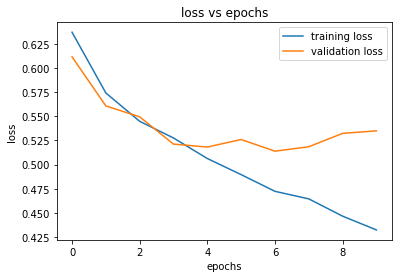

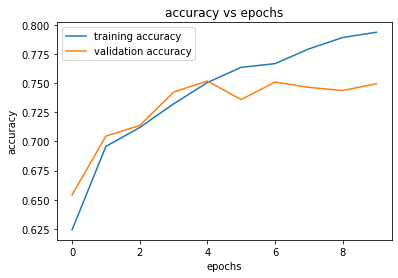

In [23]:
plot_graph(history_gru,'loss')
plot_graph(history_gru,'accuracy')

In [24]:
modelgru_y_pred = model_gru.predict(test_padded)

In [25]:
model2_pred_list = []
model3_pred_list = []
modelgru_pred_list = []
for i in model2_y_pred:
    if i > 0.4:
        model2_pred_list.append(1)
    else:
        model2_pred_list.append(0)

for i in model3_y_pred:
    if i > 0.4:
        model3_pred_list.append(1)
    else:
        model3_pred_list.append(0)

for i in modelgru_y_pred:
    if i > 0.4:
        modelgru_pred_list.append(1)
    else:
        modelgru_pred_list.append(0)

In [26]:
submission1 = df_test.drop(columns = ['TEXT','LABEL'])
submission1['LABEL'] = model2_pred_list
submission1.to_csv('submission_lstm_embedding2.csv', index=False)

submission2 = df_test.drop(columns = ['TEXT','LABEL'])
submission2['LABEL'] = model3_pred_list
submission2.to_csv('submission_bi-lstm_embedding2.csv', index=False)

submissiongru = df_test.drop(columns = ['TEXT','LABEL'])
submissiongru['LABEL'] = modelgru_pred_list
submissiongru.to_csv('submission_gru_embedding2.csv', index=False)